**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1LSsSkdJGX2yZgVw8LlFJNwuNGBlfVqMp?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1HnNwTTLKHH32p3EnqYlKZSy9SctXDvp8?usp=sharing)
3. Практический ноутбук 2


## Обучение агента на среде [ViZDoom](https://github.com/mwydmuch/ViZDoom)

Сценарий «Защищай центр» (defend the center).

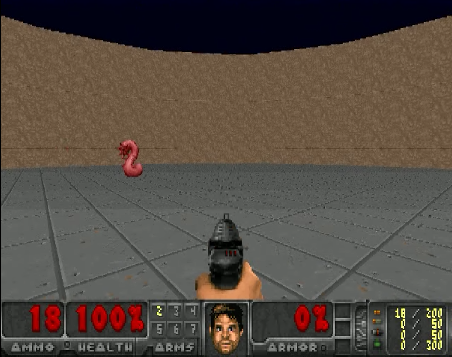

Чтобы запустить среду ViZDoom в колаб-ноутбуке, нам нужно сначала установить различные дополнительные программы, которые упоминаются в официальной документации.

In [ ]:
%%bash
# %%bash — значит используем командную строку (не код Python)
# Устанавливаем нужные программы, которые требует от нас документация 

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 https://cloud.r-project.org/bin/linux/u

In [ ]:
!pip install imageio==2.4.1

Устанавливаем саму библиотеку ViZDoom из ее GitHub репозитория.

In [ ]:
# Обычно уходит 5-10 минут на установку этой библиотеки
!pip install vizdoom==1.1.11

     |████████████████████████████████| 4.5 MB 8.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.11-cp37-cp37m-linux_x86_64.whl size=14093081 sha256=5946cdbef702065e038edd7836f9e8e2fc6295211e6300beb00fc6dd1667dbe3
  Stored in directory: /root/.cache/pip/wheels/54/1f/79/3c4fb32f327b836d5ec085c494d12aafd488256f8261ea119d
Successfully built vizdoom


Подключаемся к диску и импортируем все нужные модули и библиотеки.

Cкачиваем все нужные файлы для среды ViZDoom.

In [ ]:
import gdown #Импортируем модуль для скачивания датасетов

#Скачиваем файлы для ViZDoom
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l6/rl.zip', output = None, quiet = True)
!unzip -qo rl.zip -d /content/ViZDoom/ #Разархивируем файлы

In [ ]:
# Импортируем все функции из cреды ViZDoom
from vizdoom import * 

# Библиотека TensorFlow
import tensorflow as tf 

# Библиотека NumPy
import numpy as np  

# Импортируем модуль для генерации рандомных значений
import random   

# Модуль для сохранения результатов в файл
import pickle  

# Модуль для работы с картинками и видео (нужен для предобработки данных и записи результата)
import cv2                    

# Тип данных deque (список, где автоматически удаляются старые значения при добавлении новых, чтобы не переполнять память)
from collections import deque    

# Модуль pyplot из библиотеки Matplotlib
import matplotlib.pyplot as plt 

# Функция для создания и загрузки модели из TensorFlow
from tensorflow.keras.models import load_model, Model, Sequential 

# Все слои из Keras
from tensorflow.keras.layers import *                             

# Оптимизатор RMSprop
from tensorflow.keras.optimizers import RMSprop                   

# Модуль для бэкэнда Keras
from tensorflow.keras import backend as K    

# Функция для удобного onehot энкодинга
from tensorflow.keras.utils import to_categorical    

# Функции для воспроизведения видео с результатом
from moviepy.editor import *  

# Функция для управления выводом в колаб-ячейках
from google.colab import output                                   

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2113536/45929032 bytes (4.6%)4251648/45929032 bytes (9.3%)6356992/45929032 bytes (13.8%)7798784/45929032 bytes (17.0%)9920512/45929032 bytes (21.6%)12181504/45929032 bytes (26.5%)14262272/45929032 bytes (31.1%)16629760/45929032 bytes (36.2%)18939904/45929032 bytes (41.2%)21397504/45929032 bytes (46.6%)23166976/45929032 bytes (50.4%)25509888/45929032 bytes (55.5%)27402

In [ ]:
from google.colab import drive                    # Для работы с Google Drive
drive.mount('/content/drive', force_remount=True)

## Создание функций

Функции будут создавать нейронную сеть, извлекать данные, преобразовывать данные, обучать нейронную сеть и т. д. 

### 1. Функция создания нейросети



Здесь используется классическая DQN-нейросеть, которая принимает небольшую последовательность кадров из игровой среды на вход. На выходе будет столько же нейронов, сколько возможных дискретных действий в среде. Каждый нейрон предсказывает значение ожидаемой награды (Q(s, a)) за соответствующее действие.

Функция, представленная ниже, будет использована для создания основной и целевой моделей.

In [ ]:
def Make_DQN(input_shape, 
             action_size, 
             learning_rate):
  
  ''' Функция создания нейросети

      Args:
        input_shape -  
        action_size -  
        learning_rate - 
      
      Returns: возвращает готовую, компилированную модель
  
  '''
  model = Sequential()                                                                       
  model.add(Conv2D(32, 8, strides = (4,4), activation = 'relu', input_shape=(input_shape)))  
  model.add(Conv2D(64, 4, strides = (2,2), activation = 'relu'))                             
  model.add(Conv2D(64, 4, activation = 'relu'))
  model.add(Flatten())                                                                       
  model.add(Dense(512, activation = 'relu'))                                                                            
  model.add(Dense(action_size, activation = 'linear')) # Выходной слой должен иметь активационную функцию 'linear' — мы предсказываем награды на выходе НС.

  # Практика показывает, что RMSprop — хороший оптимизатор для обучения с подкреплением, однако можно использовать adam.
  optimizer = RMSprop(lr = learning_rate) 
  
  # Компилируем модель с функцией ошибки mse и заданным оптимизатором.
  model.compile(loss = 'mse', optimizer = optimizer) 

  return model     

### 2. Функция обновления весов в целевой модели 

Она будет создаваться позже.

In [ ]:
def update_target_model(): 

  ''' Функция обновления весов в целевой модели, т. е. той, что
      устанавливает веса целевой модели (которая не обучается) такими
      же, как веса основной модели (которая обучается)
  
  '''

  target_model.set_weights(main_model.get_weights())
  main_model.save_weights('/content/drive/My Drive/model.h5')

Ниже задаются различные гиперпараметры для обучения нашей DQN-нейросети. Наиболее важные гиперпараметры:

- **`gamma` (гамма)** — параметр для передачи наград между состояниями. Значение от 0 до 1: чем больше значения этого параметра, тем больше нейронная сеть будет приоритезировать награды, которая она может получить в будущем. 

- **`observation_steps` (количество шагов наблюдения)** — количество шагов, за которые алгоритм не обучается, но добавляет в память новую информацию (состояния, действия, награды). Это необходимо, чтобы алгоритм не переобучался на маленьком объеме памяти.

- **`target_model_update_frequency` (частота обновления целевой модели)** — определяет количество шагов, после которого мы обновляем целевую модель (копируем все веса основной модели в целевую модель). В оригинальной статье по Q-learning использовалось 10 000 шагов, но в этом примере мы будем использовать 5 000 шагов.

In [ ]:
gamma = 0.95                         # Гамма   
observation_steps = 10000            # Количество шагов 
target_model_update_frequency = 5000 # Частота обновления целевой  

# Другие гиперпараметры

initial_epsilon = 1             # Начальное значение эпсилона (вероятность принять рандомный шаг)    
epsilon = initial_epsilon       # Текущее значение эпсилона (инициализируется как стартовое значение)
final_epsilon = 0.01            # Минимальное значение эпсилона (должен быть выше 0)
epsilon_decay_steps = 200000    # Мы будем уменьшать значение эпсилона на протяжении 200 000 шагов    
epsilon_decay_factor = (initial_epsilon - final_epsilon)/epsilon_decay_steps  # Задаем количество, на которое будем снижать эпсилон после каждого шага  

timesteps_per_train = 100       # Обучаем модель раз в 100 шагов (не обязательно ждать до конца игры)
learning_rate = 1e-4            # Обычно в обучении с подкреплением ставят низкий шаг обучения, например 1e-4
batch_size = 32                 # Используем размер пакета в 32    

### 3. Функция предобработки изображений



Картинки игровой среды будут довольно большими (порядка 320×480 или 640×960), что нам не нужно. Пережмем их в меньший размер (64×64).

По умолчанию картинки цветные, но для нашей сети достаточно иметь черно-белые. Это уменьшит занимаемую память и увеличит скорость обработки.

Особенность среды в том, что изображения имеют другую размерность относительно привычной — (3, width, height) вместо (width, height, 3). Восстановим расположение осей.

Cоздадим функцию для выполнения операций выше.

In [ ]:
image_width = 64   # Ширина картинки (кадра)
image_height = 64  # Высота картинки (кадра)

num_frames = 4     # Количество последовательных кадров в одном состоянии (используется позже)

# Размерность каждого состояния — размер картинки:
state_shape = (image_width, image_height, num_frames) 

In [ ]:
def preprocess_frame(frame):
  
  ''' Функция преобразования изображений
      
      Args:
        frame - 

      Returns:
        Возвращаем предобработанное, нормализованное, решейпнутое изображение
  
  ''' 
  # Меняем оси:
  frame = np.rollaxis(frame, 0, 3) 
  
  # Меняем размерность картинки на (64×64):
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) 
  
  # Переводим в черно-белое:
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

  return frame.reshape(image_width, image_height, 1)/255 

### 4. Функция предобработки наград

Награды могут назначаться автоматически, однако желательно регулировать их вручную. Однозначный плюс среды ViZDoom — мы можем легко менять логику, с которой назначаются награды за различные события в среде (например, убил врага = 100 очков награды).



Функция будет принимать информацию из игры на текущее и предыдущее состояния на вход, а также булевое значение, если кадр последний в эпизоде. В соответствии с этой информацией мы можем задавать награду `r(s, a)`, по которой наш алгоритм будет обучаться.

Информация, которая содержится в массивах `previous_misc` и `current_misc`, а также индексы, могут отличаться в зависимости от конкретного сценария из ViZDoom.

Эту информацию можно посмотреть или поменять в соответствующих `.cfg` файлах, с помощью которых строится среда. 

Функция заточена под сценарий, который рассматривается на уроке. При использовании других сценариев функцию нужно поменять.

In [ ]:
def get_reward(previous_info, 
               current_info, 
               episode_done):

    ''' Функция предобработки наград

        Args:
            previous_misc — информация об игровой среде на предыдущем кадре (количество убитых врагов, патроны и здоровье)
            current_misc — информация об игровой среде на текущем кадре (количество убитых врагов, патроны и здоровье)
            episode_done — булевое значение, которое говорит, если кадр последний в эпизоде.
            misc[0] — количество убитых врагов, misc[1] — патроны, misc[2] — здоровье
        
        Returns: подсчитанная награда
               
    '''   
    
    # Инициализируем награду как 0
    reward = 0     
    
    # Если кадр последний в игре, ставим награду как -0.1 и возвращаем ее (агент умер)
    if episode_done:                          
        reward = -0.1
        
        return reward
    
    # Если убили врага в кадре, увеличиваем награду на 1
    if current_info[0] > previous_info[0]:   
        reward += 1
    
    # Если потеряли здоровье, уменьшаем награду на 0.1
    if current_info[1] < previous_info[1]:   
        reward -= 0.1
    
    # Если использовали патрон, уменьшаем награду на 0.1
    if current_info[2] < previous_info[2]:   
        reward -= 0.1

    return reward  

### 5. Функция предсказания награды

Создадим функцию, по которой наш агент будет принимать действие. В этой функции нейронная сеть будет предсказывать награду, к которой нас приведет каждое дискретное действие (Q(s', a)). 



Начнем с генерации рандомного значения при помощи `random.random()` и сравнения его с `epsilon`. Если оно меньше или равно (т. е. с вероятностью эпсилон или меньше, мы берем рандомное действие).

В зависимости от соотношения рандомно сгенерированного числа и текущего значения эпсилон (е) у нас будет вероятность `1-e`, принять действие которой должно привести к наибольшей награде и вероятность принять рандомное действие (это нужно, чтобы агент исследовал среду и познавал новую информацию).

Также для удобства зададим код для снижения значения эпсилон при каждом вызове этой функции.

In [ ]:
def get_action(state, 
               epsilon, 
               action_size):
    
  ''' Функция предсказания награды за действие

      Args: state -
            epsilon - 
            action_size -

      Returns: выбранное действие и новое значение epsilon
  
  '''

  # Генерируем рандомное значение и сравниваем
  if random.random() <= epsilon:                     
    action_index = np.random.randint(0, action_size)  
  
  # Иначе (если рандомное число больше, чем эпсилон)
  else:                                              
    # Предсказываем все Q-значения при следующим действии (Q(s, a) для каждого действия a)
    Q_values = main_model.predict(np.expand_dims(state, axis = 0)) 
    # Извлекаем индекс действия который приводит к максимальному значению Q(s, a)
    action_index = np.argmax(Q_values)                             

  # Снижаем значение эпсилон, если оно больше, чем final_epsilon, снижаем значение epsilon на epsilon_decay_factor.
  if epsilon > final_epsilon:                        
    epsilon -= epsilon_decay_factor

  return action_index, epsilon                       

### 6. Функция для записи информации в память

Создаем буфер памяти. В ходе обучения мы будем сэмлировать примеры из буфера рандомным образом, чтобы избежать переобучения. 



Для создания буфера мы используем специальный тип данных из встроенного модуля Python, который называется deque. Deque работает также, как обычный питоновский список, но с одним важным отличием — у него есть максимальная длина (максимальное количество элементов, которое может храниться одновременно).

Когда эта максимальная длина превышается, и в deque добавляется новый элемент, также будет удаляться самый старый элемент. В итоге у нас будет буфер памяти, который хранит данные за большое количество игр, но автоматически удаляет очень старые данные, по которым уже несколько раз происходило обучение. Все это заложено внутри самого объекта deque, из-за чего им очень удобно пользоваться для решения подобных задач.

In [ ]:
# В памяти будет храниться не более 40 000 пар текущих и следующих состояний, действия которых нейронная сеть выбрала, а также их соответствующие награды
maximum_memory_length = 40000          

# Создаем буфер памяти
memory = deque([], maxlen = maximum_memory_length) 

Нужно также создать функции, которые будут записывать данные и память, и извлекать из нее данные для обучения нейронной сети. Память будет содержать:

- массивы из состояния среды;
- действие, которое было в нем принято;
- награду, которая была получена;
- следующее состояние, к которому действие привело;
- булевое значение, которое сообщает нам, если кадр последний в эпизоде.

In [ ]:
def add_to_memory(previous_state, 
                  action, 
                  reward, 
                  current_state, 
                  episode_done):
  
  ''' Функция записи информации в память
      
      Args:
        previous_state — массивы из состояния среды
        action — действие, которое было в нем принято
        reward — награда, которая была получена 
        current_state — следующее состояние, к которому действие привело 
        episode_done — булевое значение флагов окончания игры (кадр последний в эпизоде)

      Returns:
  '''
  
  # memory — глобальная переменная. Мы записываем в нее всю нужную информацию:
  memory.append((previous_state, action, reward, current_state, episode_done))  

### 7. Создаем функцию сэмплирования данных





> **Сэмплирование** (сэмплинг, выборка) — выделение подмножества данных из всех собранных системой веб-аналитики данных и создание отчетов на их основе. Сэмплирование позволяет выбирать необходимое соотношение между скоростью и точностью расчета. 

Например, необходимо рассчитать количество достижений цели. Можно посчитать, сколько их было в 1/10 от всех сеансов за отчетный период, умножить полученный результат на 10 и получить примерное количество достижений цели. В данном примере сэмплирование — 1/10 или 10%.

Для начала зададим размер памяти. Для этого выберем минимальное из текущего размера памяти или произведения `batch_size` и `timesteps_per_train`. Сэмплируем данные.

Далее нужно создать массивы из нулей под все данные, которые извлекаются из памяти, и копировать в эти массивы наши данные из памяти. Иначе мы не сможем конвертировать сэмплированные куски deque-объекта в один массив для подачи в нейронную сеть.

В конце перебираем данные, которые ранее извлекли из памяти, копируем их значения в массивы нулей.

In [ ]:
def sample_from_memory():

  ''' Функция сэмплирования данных
      
      Args: 

      Returns: распакованные данные
  '''     
  
  # Определим размер памяти: 
  memory_batch_size = min(batch_size * timesteps_per_train, len(memory))      
  
  # Сэмплируем данные:
  mini_batch = random.sample(memory, memory_batch_size) 

  # Создаем массив из нулей с размерностью предыдущих состояний, массива действий, массива наград, текущих состояний, флагов окончания игры
  previous_states = np.zeros((memory_batch_size, image_width, image_height, num_frames))   
  actions = np.zeros(memory_batch_size)                                                     
  rewards = np.zeros(memory_batch_size)                                                    
  current_states = np.zeros((memory_batch_size, image_width, image_height, num_frames))    
  episode_done = np.zeros(memory_batch_size)                                               

  # Перебираем данные и копируем их значения в массивы нулей:
  for i in range(memory_batch_size):                  
    previous_states[i, :, :, :] = mini_batch[i][0]  
    actions[i] = mini_batch[i][1]                   
    rewards[i] = mini_batch[i][2]                   
    current_states[i, :, :, :] = mini_batch[i][3]   
    episode_done[i] = mini_batch[i][4]             

  return previous_states, actions.astype(np.uint8), rewards, current_states, episode_done  

### 8. Функция для обучения нейронной сети

Модель будет обучаться предсказывать нужные Q-значения после получения состояния на вход. 

Для этого нам нужно будет определить Q-значения в соответствии с уравнением Беллмана. 

Создадим функцию `train_network()`. Начнем с извлечения распакованного пакета данных из памяти, предсказания значения  `Q(s, a)` и `Q(s', a')` (по целевой модели).

Затем нужно модифицировать значения Q в соответствии с уравнением Беллмана, чтобы нейронная сеть обучалась:
- если состояние последнее в эпизоде, значение за выбранное действие будет наградой из среды;
- если состояние не последнее в эпизоде, присваиваем новое значение.

Иначе мы знаем только значение выбранного действия, потому что мы только его «видели». Пооэтому мы можем обновить значение только для этого действия.

Обучаем модель, чтобы она предсказывала Q-значения для всех действий из состояния.

In [ ]:
def train_network(): 

  ''' Функция обучения алгоритма
      
      Args: 

      Returns: обученная модель
  '''        

  # Извлекаем пакет данных из памяти:
  previous_states, actions, rewards, current_states, game_finished = sample_from_memory()

  # Предсказываем Q(s, a):   
  Q_values = main_model.predict(previous_states)                                            
  
  # Предсказываем Q(s', a'):  
  next_Q_values = target_model.predict(current_states)                                      

  # Модифицируем значения Q: 
  for i in range(len(current_states)): 

    # Если состояние последнее в эпизоде:  
    if game_finished[i]:               
      Q_values[i, actions[i]] = rewards[i]
    # Если состояние не последнее в эпизоде: 
    else: 
      Q_values[i, actions[i]] = rewards[i] + gamma * next_Q_values[i, actions[i]] 

  # Обучаем модель: 
  main_model.fit(previous_states, Q_values, batch_size = batch_size, verbose = 0) 

### 9. Функция для визуализации результатов агента 

Функция будет отображать награду, скользящее среднее награды (за 20 эпизодов), количество убитых врагов, а также количество оставшихся патронов в конце каждого эпизода.


In [ ]:
def show_scores(scores, 
                killcount, 
                ammo):

  ''' Функция визуализации результата
      
      Args:
        scores -  
        killcount -  
        ammo -

      Returns: график
  '''     

  # Удаляем предыдущий вывод ячейки:
  output.clear() 

  # Создаем два сабплота (в левом будут награды и средние награды, в правом будут количества убитых врагов и патронов): 
  fig, axes = plt.subplots(1, 2, figsize = (20, 8)) # Делаем размер графика большим

  # Устанавливаем большой размер полотна:
  axes[0].plot(scores, label = "Награда за эпизод")                          
  # Отрисовываем скользящие средние награды:
  axes[0].plot(moving_average(scores), label = "Скользящее среднее награды") 
  # Добавляем лейблы осей:
  axes[0].set_xlabel("Итерация", fontsize = 16)                              
  axes[0].set_ylabel("Награда", fontsize = 16)
  # Добавляем легенду к графику:
  axes[0].legend()                                                           

  # Отрисовываем количество убитых врагов:
  axes[1].plot(killcount, 'red', linestyle = '--', label = "Количество убитых врагов (сумма за 10 эпизодов)")              
  # Отрисовываем количество убитых врагов (скользящее среднее):
  axes[1].plot(moving_average(killcount), 'black', label = "Количество убитых врагов (скользящее среднее за 10 итераций)") 
  # Отрисовываем количество оставшихся патронов:
  axes[1].plot(ammo, 'green', linestyle = '--', label = "Осталось патронов (сумма за 10 эпизодов)")                        
  # Отрисовываем количество оставшихся патронов (скользящее среднее):
  axes[1].plot(moving_average(ammo), 'blue', label = "Осталось патронов (скользящее среднее за 10 итераций)")              
  # Добавляем лейблы осей:
  axes[1].set_xlabel("Итерация", fontsize = 16)  
  axes[1].set_ylabel("Значение", fontsize = 16)
  # Добавляем легенду к графику:
  axes[1].legend()                               

  # Отображаем график:
  plt.show()   

### 10. Функция подсчета скользящего среднего



Из-за случайности факторов в среде и в самом алгоритме, награда и длина эпизода будут сильно варьироваться при обучении, что приведет к сложностям при нахождении какой-либо тенденции. 

Поэтому мы также будем считать скользящие средние от всех анализируемых данных. Скользящее среднее за большое количество эпизодов (в данном случае 50) — наиболее надежная метрика для обнаружения какой-либо тенденции в обучении. Для подсчета скользящего среднего используется функция математической свертки. Мы будем считать скользящее среднее за 10 значений.

Сравниваем текущую длину свертки и длину датасета, выбираем минимальное.

Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива).

Возвращаем скользящее среднее.

In [ ]:
def moving_average(data, 
                   width = 10): 
  
  ''' Функция для подсчета скользящего среднего всех значений
      
      Args:
        data — входной массив, 
        width — длина, на которую считаем скользящее среднее
      
      Returns: результат свертки данных на фильтр из единиц — наше скользящее среднее 
  '''

  # Длина свертки:  
  width = min(width, len(data))    

  # Создадим паддинг для свертки:  
  data = np.concatenate([np.repeat(data[0], width), data])         
  
  # Возвращаем результат свертки: 
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  

## Создание игровой среды, инициализация нейронной сети

В данном уроке мы будем обучать бота играть в сценарий, который называется «Защищай центр» (defend the center). Игрок находится в центре большой круглой комнаты, где появляются различные враги.

У игрока есть пистолет с 26 патронами. Игрок может совершать три действия: повернуть влево, повернуть вправо, выстрелить. Игра заканчивается, когда игрока убивают монстры, что в любом случае произойдет (когда патроны закончатся, игрок не сможет убегать, и его убьют). Цель игрока — убить максимальное количество монстров до того, как закончатся патроны. В идеале игрок может убить 26 монстров.



In [ ]:
# Инициализируем среду:
game = DoomGame() 

# Загружаем сценарий «Защищай центр»:
game.load_config("/content/ViZDoom/scenarios/defend_the_center.cfg") #Загружаем сценарий «Защищай центр»

# Устанавливаем размер кадров среды (будет 640×480):
game.set_screen_resolution(ScreenResolution.RES_640X480) 

# Нужно отключить окно, чтобы не было ошибки:
game.set_window_visible(False) 

# Инициализируем игру:
game.init() 

# Извлекаем количество возможных уникальных действий:
action_size = game.get_available_buttons_size()                 

# Создаем основную модель (будет обучаться):
main_model = Make_DQN(state_shape, action_size, learning_rate)   

# Создаем целевую сеть (не будет обучаться, периодически будет обновляться под основную модель):
target_model = Make_DQN(state_shape, action_size, learning_rate) 

# Устанавливаем параметры целевой модели (копируем в нее значения основной модели):
update_target_model()                                           

# Устанавливаем количество кадров за каждое действие. Нам не нужен каждый кадр, 
# поэтому будем совершать действие и брать новое состояние лишь раз в 4 кадра:
frames_per_action = 4  

Алгоритмы RL долго обучаются, и часто одной сессии Colab не хватает. В следующим блоке можно загружать веса обученной модели, а также полезные статистики, чтобы продолжить обучение. 

Если обучение начинается с нуля, то мы просто инициализируем списки, где будет храниться полезная статистика.

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l6/vizdoom_DQN_stats.txt', None,quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l6/vizdoom_DQN_model.h5', None,quiet=True)

'vizdoom_DQN_model.h5'

In [ ]:
load_pretrained = True #Решаем, если мы обучаем модель с нуля или продолжаем предыдущую сессию обучения

#Если хотим продолжить текущее обучение, загружаем сохраненные веса для основной и целевой моделей:
if load_pretrained:
  main_model.load_weights('/content/vizdoom_DQN_model.h5')
  target_model.load_weights('/content/vizdoom_DQN_model.h5')
  #Также загружаем ранее сохраненные статистики из pickle файла:
  with open('/content/vizdoom_DQN_stats.txt', 'rb') as f:
    record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon = pickle.load(f)

#Иначе мы просто инициализируем списки, в которых будет храниться статистика о работе агента:
else:
  record_rewards = []          #Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            #Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            #Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     #Инициализируем номер эпизода как 1
  timestep = 0           #Инициализируем номер шага как 0

## Создание игрового цикла

В нем агент будет играть в игру и обучаться.

Данная игра и алгоритм относительно простые, и в итоге он обучается примерно 10 часов на процессоре в Colab (результаты видны после ~5 часов). Другие алгоритмы или даже тот же алгоритм в более сложной среде могут обучаться намного дольше.

Инициализируем переменные и проведем предобработку:

In [ ]:
# Генерируем новый эпизод:
game.new_episode()

# Извлекаем первый кадр (это еще не полноценное состояние):                        
game_data = game.get_state()    

# Извлекаем информацию об игре (количество убитых врагов, патроны, здоровье):
current_info = game_data.game_variables   

# Записываем информацию о текущем моменте как 'предыдущий' момент (чтобы потом мы могли сравнить разницу):
previous_info = current_info             

# Извлекаем кадр из игры (480×640):
frame = game_data.screen_buffer                                                       
# Предобрабатываем кадр в черно-белый (размер 64×64):
processed_frame = preprocess_frame(frame)                                             

# В качестве первого состояния просто дублируем кадр 4 раза:
current_state = np.stack([processed_frame.reshape(64, 64)] * num_frames, axis = 2)    
# Инициализируем предыдущий шаг как текущий шаг:
previous_state = current_state  

# Инициализируем награды:

interval_reward = 0  # за интервал (10 эпизодов) как 0
interval_kills = 0   # за количество убитых врагов (10 эпизодов) как 0
interval_ammos = 0   # за количество оставшихся патронов (10 эпизодов) как 0

Обучение:

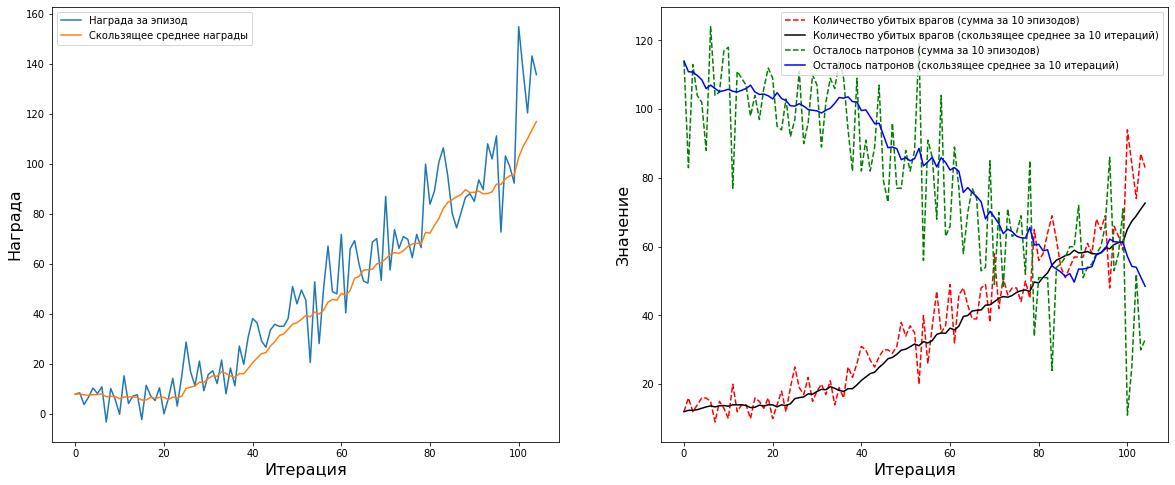

Статистика успешно сохранена.


In [ ]:
while episode_number<1500:
  
  # Увеличиваем номер шага на 1:
  timestep += 1 
  # Извлекаем индекс награды и новое значение эпсилон:
  action_index, epsilon = get_action(previous_state, epsilon, action_size)  
  # Приводим награду в onehot массив:
  action_onehot = to_categorical(action_index)                              
  # Подаем действие в игровую среду в качестве списка: 
  game.set_action(action_onehot.tolist())                                   
  # Игра продвигается на 4 кадра (значение frames_per_action):
  game.advance_action(frames_per_action)                                    

  # Предобрабатываем кадр в черно-белый (размер 64×64×1):
  game_data = game.get_state()                                    

  # Проверяем, если эпизод закончился:
  episode_done = game.is_episode_finished() 

  # Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод:
  if episode_done: 
    print(f"Закончился {episode_number}-й эпизод. Значение эпсилон: {round(epsilon, 2)}, Количество убитых врагов: {current_info[0]}, количество оставшихся патронов: {current_info[1]}")

    episode_number += 1   # Увеличиваем номер эпизода на 1:
    interval_kills += current_info[0]
    interval_ammos += current_info[1]

    # Чтобы не собирать слишком много данных и чтобы их было удобно отображать на графике

    # Записываем результат раз в 10 эпизодов:
    if episode_number % 10 == 0 and episode_number > 0: 
      
      # Добавляем награду в список всех наград:
      record_rewards.append(interval_reward)            
      # Добавляем количество убитых врагов:
      record_kills.append(interval_kills)               
      # Добавляем количество неиспользованных патронов:
      record_ammos.append(interval_ammos)               
      # Записываем результаты в графики:
      show_scores(record_rewards, record_kills, record_ammos)  

      # Сохраняем веса модели:
      main_model.save_weights('/content/vizdoom_DQN_model.h5') 
      
      # Записываем статистику в файл через библиотеку pickle:
      with open('/content/vizdoom_DQN_stats.txt', 'wb') as f:  
        pickle.dump([record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon], f) 
      print("Статистика успешно сохранена.")

      # Заново инициализируем значения статистики для интервала в 10 эпизодов:
      interval_reward, interval_kills, interval_ammos = 0, 0, 0 

    # Начинаем новый эпизод игры:
    game.new_episode()                       
    # Извлекаем новое состояние игры:
    game_data = game.get_state()             

  # Извлекаем информацию об игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровье):
  current_info = game_data.game_variables   
  # Извлекаем новый кадр из игры:
  frame = game_data.screen_buffer           
  # Предобрабатываем кадр (новая размерность будет 64×64×1):
  processed_frame = preprocess_frame(frame)    
  # Обновляем состояние — удаляем последний кадр и добавляем новый:
  current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) 

  # Извлекаем награду за шаг из среды (логика, которую не можем менять):
  environment_reward = game.get_last_reward()                           
  # Извлекаем награду за шаг из самописной функции (самописная награда, значит, можем менять логику):
  custom_reward = get_reward(previous_info, current_info, episode_done) 
  # Общая награда — это сумма награды из среды и самописной награды:
  reward = environment_reward + custom_reward 

  # Добавляем награду в переменную для статистики:
  interval_reward += reward 

  # Добавляем предыдущее состояние, действие, награду и текущее состояние в память:
  add_to_memory(previous_state, action_index, reward, current_state, episode_done) 
  
  # Обучаем нашу модель раз в 100 шагов, но только если у нас достаточно данных в памяти:
  if timestep % timesteps_per_train == 0 and len(memory) > observation_steps: 
    train_network()

  # Обновляем целевую модель весами основной модели раз в заданное количество (5 000) шагов:
  if timestep % target_model_update_frequency == 0: 
    update_target_model()

  # Запоминаем предыдущую информацию:
  previous_info = current_info    
  # Запоминаем предыдущее состояние:
  previous_state = current_state  

Эпсилон достиг своего минимального значения примерно на 1 500 эпизоде.

## Создание видео с игрой агента

Мы запишем 10 игр и посмотрим на результат. Для записи игр будет использоваться список, куда мы будем записывать каждый кадр из игры. Этот массив кадров затем будет обработан и конвертирован в видео.

In [ ]:
# Кадры из игр будут записываться в этот массив:
video_frames = []  
# Устанавливаем эпсилон как 0 (после обучения):
epsilon = 0        

# Снова инициализируем среду:
game = DoomGame() 
# Загружаем сценарий «Защищай центр»:
game.load_config("/content/ViZDoom/scenarios/defend_the_center.cfg") 
# Устанавливаем размер кадров среды (будет 640×480):
game.set_screen_resolution(ScreenResolution.RES_640X480) 
# Нужно отключить окно, чтобы не было ошибки:
game.set_window_visible(False) 
# Снова инициализируем игру:
game.init() 

# Создаем основную модель (будет управлять агентом):
main_model = Make_DQN(state_shape, action_size, learning_rate)   
main_model.load_weights('/content/vizdoom_DQN_model.h5')

# Генерируем новый эпизод:
game.new_episode()      
# Извлекаем первый кадр (это еще не полноценное состояние):                  
game_data = game.get_state()              

# Извлекаем кадр из игры (480×640):
frame = game_data.screen_buffer                                                       
# Предобрабатываем кадр в черно-белый (размер 64×64):
processed_frame = preprocess_frame(frame)                                             
# В качестве первого состояния просто дублируем кадр 4 раза:
current_state = np.stack([processed_frame.reshape(64, 64)] * num_frames, axis = 2)    
# Записываем текущее состояние в предыдущее состояние:
previous_state = current_state    

while True:
  # Извлекаем индекс награды и новое значение эпсилон:
  action_index, epsilon = get_action(current_state, epsilon, action_size)   
  # Приводим награду в onehot-массив:
  action_onehot = to_categorical(action_index)                              
  # Подаем действие в игровую среду в качестве списка:
  game.set_action(action_onehot.tolist())                                    
  # Игра продвигается на 4 кадра (значение frames_per_action):
  game.advance_action(frames_per_action)                                    

  # Предобрабатываем кадр в черно-белый (размер 64×64×1):
  game_data = game.get_state()                                    

  # Проверяем, если эпизод закончился:
  episode_done = game.is_episode_finished() 

  # Нам необходимо возобновить среду и записать нужные статистики, когда заканчивается эпизод:
  if episode_done: 
    
    # Затем необходимо начать новый эпизод игры:
    game.new_episode()                      
    # Извлекаем новое состояние игры:
    game_data = game.get_state()            
    # Выходим из игрового цикла:
    break 

  # Извлекаем новый кадр из игры:
  frame = game_data.screen_buffer           
  # Добавляем кадр в массив, меняем формат размерности (3, width, height) -> (width, height, 3):
  video_frames.append(np.rollaxis(frame, 0, 3)) 

  # Предобрабатываем кадр (новая размерность будет 64×64×1):
  processed_frame = preprocess_frame(frame)    
  # Обновляем состояние — удаляем последний кадр и добавляем новый:
  current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) 

  # Запоминаем предыдущее состояние:
  previous_state = current_state  

## Запись результата в видео

У нас есть массив кадров, и нам нужно конвертировать его в видео. Для этого используем библиотеку CV2. Создаем объект для воспроизведения видео (задаем путь к файлу видео, формат видео, кадры в секунду и размер изображений).

In [ ]:
# Чем больше кадров в секунду, тем быстрее будет проигрываться видео
out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (640, 480)) 

# В цикле добавляем каждый кадр в видео (делаем предобработку кадра — меняем каналы с RGB в BGR, поскольку CV2 воспринимает каналы как BGR):
for i in range(len(video_frames)):   
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))

# Закрываем объект для создания видео:
out.release()   

## Отображение видео в Colab

Для этого мы снова обратимся к библиотеке moviepy. Конкретно мы будем использовать функцию VideoFileClip для воспроизведения видео.

In [ ]:
# Указываем путь к видео:
path="/content/episode.avi" 

# Извлекаем видео из заданного пути (куда мы ранее записали видео через CV2):
clip=VideoFileClip(path) 

# Отображаем видео в Colab:
clip.ipython_display(width=640, maxduration = 40) 

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1LSsSkdJGX2yZgVw8LlFJNwuNGBlfVqMp?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1HnNwTTLKHH32p3EnqYlKZSy9SctXDvp8?usp=sharing)
3. Практический ноутбук 2
